# Boosting para el dataset EuroSAT

# 1. Acceso a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Importando módulos

In [26]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 3. Lectura de los datos

In [27]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.3 Árbol de decisión'
train_path = os.path.join(path,'EUROSAT_TRAIN_FEAT.csv')

In [28]:
train_df = pd.read_csv(train_path)
clases = train_df['label'].unique()
train_df.head()

,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,color_16,color_17,color_18,color_19,color_20,color_21,color_22,color_23,color_24,color_25,color_26,color_27,color_28,color_29,color_30,color_31,color_32,color_33,color_34,color_35,color_36,color_37,color_38,color_39,...,color_493,color_494,color_495,color_496,color_497,color_498,color_499,color_500,color_501,color_502,color_503,color_504,color_505,color_506,color_507,color_508,color_509,color_510,color_511,texture_0,texture_1,texture_2,texture_3,texture_4,texture_5,texture_6,texture_7,texture_8,texture_9,texture_10,texture_11,texture_12,Hu_0,Hu_1,Hu_2,Hu_3,Hu_4,Hu_5,Hu_6,label
0,0.0,0.0,0.000429,0.002575,0.001717,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.014593,0.012018,0.000429,0.000000,0.0,0.0,0.0,0.0,0.00000,0.022748,0.003863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006973,23.040117,0.894417,110.144206,0.434422,203.396256,417.536707,5.810727,8.042798,0.001176,2.785816,-0.347483,0.981251,0.001636,1.474129e-10,9.088959e-13,1.238040e-13,3.785799e-26,-1.499442e-18,-1.707315e-26,AnnualCrop
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012056,8.327994,0.954820,92.368117,0.485495,128.941213,361.144472,5.391939,7.339855,0.002182,2.482645,-0.368246,0.979857,0.002638,1.679241e-09,5.095256e-11,4.445626e-11,1.772691e-21,-1.753889e-15,1.155135e-21,AnnualCrop
2,0.0,0.0,0.000000,0.007537,0.045220,0.022072,0.0,0.0,0.0,0.0,0.0,0.000000,0.058679,0.726218,0.577099,0.037145,0.0,0.0,0.0,0.0,0.00000,0.000000,0.136738,0.001077,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001521,104.983759,0.948826,1025.361539,0.308539,297.756791,3996.462396,7.336093,10.155426,0.000610,3.690089,-0.400293,0.996832,0.001118,1.542389e-09,7.932409e-13,5.521435e-12,1.154182e-23,1.639691e-16,-5.577083e-25,AnnualCrop
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000478,0.033963,0.027266,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00287,0.046879,0.647692,0.685004,0.0,0.0,0.0,0.0,0.0,0.0,0.094236,0.299928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003368,52.156309,0.957445,613.487385,0.354164,360.245280,2401.793232,6.712811,9.258063,0.000695,3.298105,-0.389142,0.993600,0.000908,2.647723e-09,1.190332e-12,1.161787e-12,-9.484001e-25,-1.877223e-18,9.834228e-25,AnnualCrop
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007743,9.679413,0.893749,45.822831,0.372521,153.012016,173.611911,5.275578,7.715428,0.001931,2.721910,-0.248826,0.930371,0.002141,2.549876e-09,1.263506e-12,3.164047e-12,-3.063017e-24,3.203858e-17,-5.535397e-24,AnnualCrop


**Enlistando las categorías de las imágenes**

In [29]:
clases = train_df['label'].unique().tolist()
n_clases = len(clases)
print(clases)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


**Visualizando distribución de clases**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



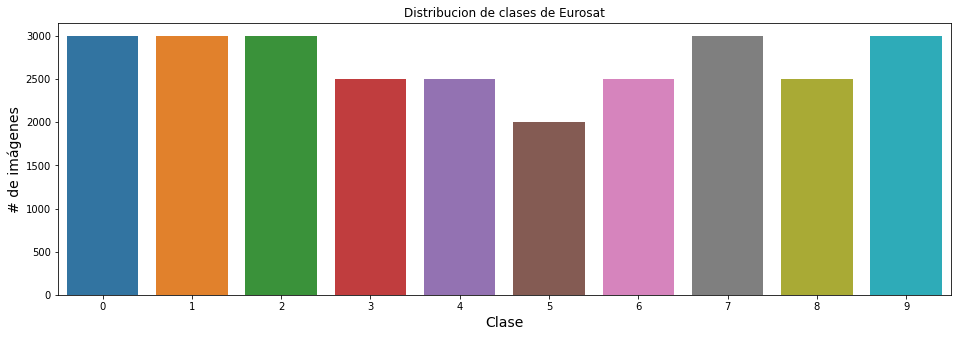

In [55]:
fig, ax =plt.subplots(figsize=(16,5))
sns.countplot('label', data=train_df)
plt.title('Distribucion de clases de Eurosat')
plt.xlabel('Clase', fontsize=14)
plt.ylabel('# de imágenes', fontsize=14)
plt.show()

**Cálculando los pesos ponderados**

In [30]:
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
print(pesos)

[0.11111111 0.11111111 0.11111111 0.09259259 0.09259259 0.07407407
 0.09259259 0.11111111 0.09259259 0.11111111]


# 3. Codificación de las etiquetas y escalamiento

**Codificación de etiquetas de la columna label**

In [31]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)

**Escalamiento de las características de 0 a 1**

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

# 4. Análisis de componentes principales

**Análisis PCA con el 95% de varianza acumulada**

In [33]:
pca = PCA(0.95)
pc = pca.fit_transform(train_df.iloc[:,:-1])
df_pca = pd.DataFrame(data = pc,
                           columns=range(pc.shape[1]))
df_pca = pd.concat([df_pca, train_df.iloc[:,-1]], axis = 1)

In [34]:
print('Número de componentes principales: %s'%len(pca.explained_variance_ratio_))
print('Varianza acumulada con %s componentes: %s'%(len(pca.explained_variance_ratio_),np.sum(pca.explained_variance_ratio_)))

Número de componentes principales: 41
Varianza acumulada con 41 componentes: 0.9519162466783112


In [35]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,label
0,0.021655,0.273502,0.102364,0.061546,0.089783,0.007629,-0.261941,0.180699,0.442403,-0.172650,-0.224836,0.114530,-0.034808,0.067837,0.423538,-0.024386,0.110547,-0.141101,0.086321,0.173991,0.115570,-0.009393,0.004314,0.066414,0.173194,0.185844,-0.125586,0.234926,0.028541,-0.153793,-0.054382,0.205413,0.176103,0.293958,0.099149,-0.171007,0.026776,-0.027670,0.016856,-0.026743,-0.087473,0
1,0.622296,0.002815,-0.496311,-0.323319,-0.172456,-0.305126,-0.063467,0.060499,0.024346,-0.127143,-0.148231,0.024083,-0.133093,-0.027994,-0.078458,-0.019692,0.027015,-0.026253,-0.005554,-0.032456,-0.013783,0.008256,0.001326,-0.024357,0.005001,-0.035209,-0.017449,-0.047436,-0.092008,-0.011180,-0.058675,0.005498,-0.009579,0.030639,0.017519,0.004390,0.006389,0.000383,-0.037476,0.017778,0.011162,0
2,-0.423656,0.636943,0.034199,-0.211894,0.302205,-0.096718,0.135345,0.042499,-0.274190,0.003008,0.143233,0.423902,-0.199390,-0.093691,0.064369,0.001861,0.106781,-0.162592,-0.220757,-0.033265,0.086973,0.079839,-0.061395,0.089294,0.052680,0.153785,0.089078,-0.114030,0.008174,0.025037,0.018815,0.014213,0.001636,-0.061935,-0.039565,-0.030199,-0.001254,0.089498,-0.017474,-0.039086,0.022252,0
3,-0.269740,0.527962,-0.008303,-0.093053,0.371391,-0.149039,-0.078730,0.035853,-0.132790,0.013478,-0.244529,0.084268,0.331820,-0.367814,0.058389,-0.297845,0.057514,0.177385,0.228286,0.311967,0.018471,-0.077127,-0.362935,-0.277048,-0.287764,-0.123875,-0.128897,0.038713,-0.010891,-0.019303,-0.039510,-0.077868,-0.051809,0.030791,0.010303,-0.063006,0.107078,0.074498,0.006476,-0.048601,0.011595,0
4,0.320276,0.251265,-0.457422,0.462987,-0.182128,-0.239392,0.289217,-0.188322,0.203603,-0.203343,-0.144228,0.100569,-0.045847,-0.040164,-0.145697,-0.105348,-0.031246,-0.035405,0.041241,-0.073813,0.023655,0.009348,-0.028434,0.012820,0.012869,-0.024933,0.022915,0.039709,-0.089881,0.043477,-0.143426,-0.056254,0.082285,0.008452,0.004522,0.013692,-0.027097,0.002386,-0.021962,-0.027664,0.016525,0


# 5. Validación para los modelos

**Dividiendo las características (vars indeps) de la etiqueta (var dep)**

In [21]:
X = np.array(df_pca.iloc[:,:-1]) 
y = np.array(df_pca['label']) 

**Hold- Out validation con 20% de datos para prueba**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=True)

print(f'Dimension de los datos de entrenamiento {X_train.shape}')
print(f'Dimension de los datos de prueba {X_test.shape}')

Dimension de los datos de entrenamiento (21600, 41)
Dimension de los datos de prueba (5400, 41)


# 6. Árbol de decisión (baseline)

**Creación de nuestro modelo sencillo con 5 niveles de decisión, de aquí partimos**

In [39]:
cart =  DecisionTreeClassifier(max_depth=5)
kfold = KFold(n_splits=10, shuffle=True)

**Entrenamiento con los datos de entrenamiento**

In [40]:
cart = cart.fit(X_train, y_train)

**Score de entrenmiento**

In [44]:
cart.score(X_train,y_train)

0.5793055555555555

**Obteniendo las predicciones**

In [41]:
y_pred = cart.predict(X_test)

**Score de los datos de prueba i.e. los predichos**

In [42]:
score = metrics.accuracy_score(y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.5677777777777778


**Matri de confusión**

In [45]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.savefig(title+'.png')
    plt.grid(False)
    plt.show()

**¿Qué observamos?**

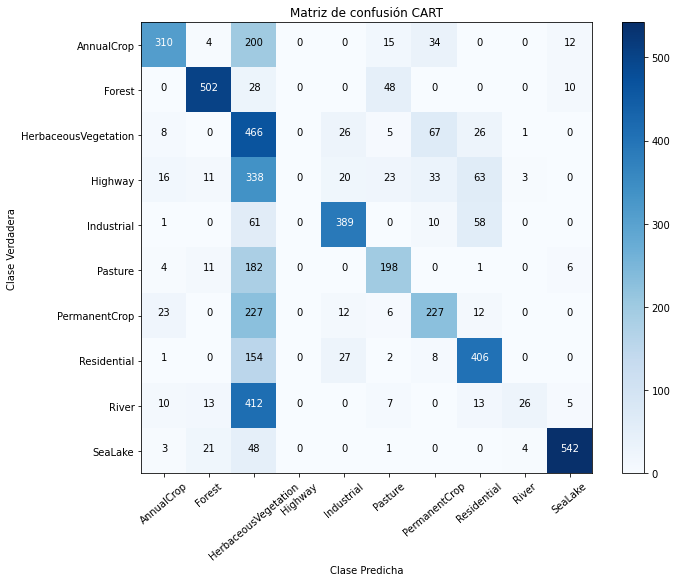

In [46]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=range(n_clases))
tit = 'Matriz de confusión CART'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

# ¿Cuántos weak learners son necesarios?

In [47]:
Xclassifiers = []
Yscore = []

# Arbol de decisión sencillo
cart =  DecisionTreeClassifier(max_depth=5)
for i in range(500):
  if i%100 == 0:
    # En cada iteración, se creará una adaboost con i+1 árboles sencillos
    boost = AdaBoostClassifier(base_estimator=cart, n_estimators=i+1)
    # Entrenando el modelo
    boost = boost.fit(X_train, y_train)
    # Prediciendo los de prueba
    preds = boost.predict(X_test)
    # Score de prueba
    score = metrics.accuracy_score(y_test, preds)
    Yscore.append(score)
    Xclassifiers.append(i+1)
    print("iter: %s, score: %s"%(i+1,np.mean(score)))


iter: 1, score: 0.5675925925925925
iter: 101, score: 0.705925925925926
iter: 201, score: 0.7411111111111112
iter: 301, score: 0.762962962962963
iter: 401, score: 0.7737037037037037


0.7737037037037037


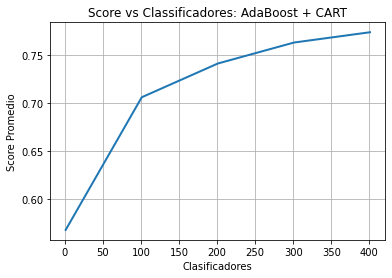

In [48]:
plt.figure()
plt.plot(Xclassifiers, Yscore, lw=2)
plt.xlabel('Clasificadores')
plt.ylabel('Score Promedio')
plt.title('Score vs Classificadores: AdaBoost + CART')
print("Score máximo alcanzado: ",np.max(Yscore)) 
plt.grid()
plt.show() 

# 7. Boosting con CART

**Creando nuestro clasificador de Boosting**

In [49]:
cart = DecisionTreeClassifier(max_depth=5)
boost = AdaBoostClassifier(base_estimator=cart, n_estimators=800)

**Entrenando al clasificador**

In [50]:
boost = boost.fit(X_train, y_train)

**Score de entrenamiento**

In [51]:
boost.score(X_train,y_train)

0.8696759259259259

**Predicciones**

In [52]:
y_pred = boost.predict(X_test)

**Score de prueba**

In [53]:
score = metrics.accuracy_score(y_test, y_pred)
score

0.794074074074074

**Matriz de confusión**

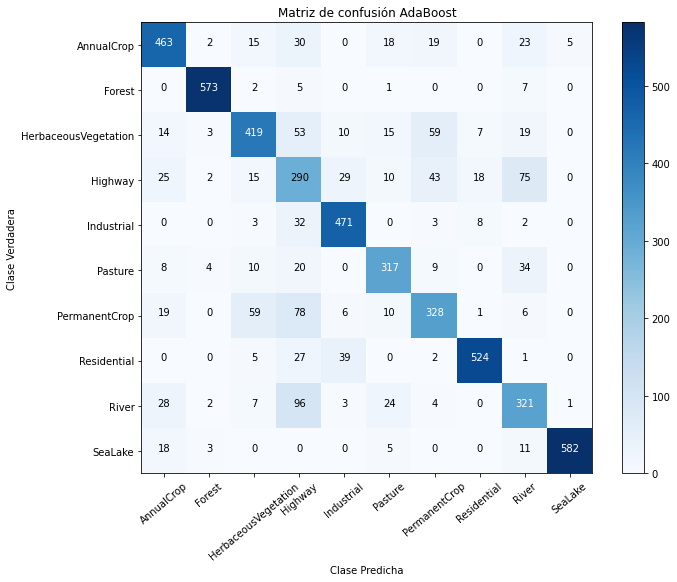

In [54]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=range(n_clases))
tit = 'Matriz de confusión AdaBoost'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)